# Proyecto 04

Te presentamos los pasos a seguir para realizar el proyecto 04.

1. Elige tu punto de partida entre dos opciones:
Tus Proyectos 01 y 02
Tu Proyecto 03
Si corresponde, emprolija lo hecho hasta el momento, incorporando las correcciones y/o sugerencias que hayas recibido de tu(s) evaluador/a (es/as).

2. Formula una nueva pregunta, problema o desafío para explorar. Aquí hay una lista no exhaustiva de opciones que puedes elegir:

3. Prueba un modelo de Machine Learning nuevo que no hayas visto en la carrera. En ese caso, debes explicar su funcionamiento y por qué consideras apropiado aplicarlo. La ganancia no necesariamente tiene que ser en desempeño, también puede ser en interpretabilidad o aplicabilidad.
4. Agrega al proyecto información de otra fuente. ¡Es sumamente válido! En ese caso, debe estar claramente explicado cómo conseguiste esos datos y qué usos esperas darles. Los datos deben ser accesibles por tu evaluador/a (por ejemplo, puedes subirlos al repositorio). Presta atención a la sensibilidad y privacidad de los datos antes de compartirlos.
5. Continúa el Análisis Exploratorio de Datos. Recuerda que es tan importante como entrenar un modelo de Machine Learning.
5. Sigue las sugerencias que te propusimos en los notebooks para continuar el Proyecto 03.

Plantea un objetivo alcanzable. En esta etapa de tu formación, es preferible un problema sencillo bien abordado que uno ambicioso que no sabes cómo abordar. El objetivo debe estar correctamente explicitado. Debes explicar qué quieres hacer y qué esperas encontrar. Imagina que es una tarea en tu trabajo y tienes que explicarle a un/a jefe/a qué vas a hacer y por qué.

### Punto de partida: Proyecto 03

#### Librerías

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import scipy.stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import Dense

pd.set_option('display.max_columns', 500)

#### Funciones

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Entrada (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### Main

In [6]:
data_2013=pd.read_csv('./Datasets/flujo-vehicular-2013.csv',sep=',')
data_2014=pd.read_csv('./Datasets/flujo-vehicular-2014.csv',sep=',')
data_2015=pd.read_csv('./Datasets/flujo-vehicular-2015.csv',sep=',')
data_2016=pd.read_csv('./Datasets/flujo-vehicular-2016.csv',sep=',')
data_2019=pd.read_csv('./Datasets/flujo-vehicular-2019.csv', sep =',')
data_2018=pd.read_csv('./Datasets/flujo-vehicular-2018.csv', sep =',')
data_2017=pd.read_csv('./Datasets/flujo-vehicular-2017.csv', sep =',')



In [7]:
#Datasets 2013 a 2015

data_2013.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2013,2013-01-01,0,Martes,Alberdi,Liviano,NO COBRADO,20
1,2013,2013-01-01,0,Martes,Alberdi,Liviano,EFECTIVO,1


In [8]:
data_2013.estacion.value_counts()

Avellaneda            226150
Dellepiane Liniers    202655
Illia                 187252
Alberdi                90344
Name: estacion, dtype: int64

In [9]:
data_2013.forma_pago.value_counts()

EFECTIVO                215282
AUPASS                  183444
EXENTO                   96496
INFRACCION               69780
NO COBRADO               65181
TARJETA DISCAPACIDAD     57029
MONEDERO                 19189
Name: forma_pago, dtype: int64

In [10]:
data_2014.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2014.0,2014-01-01,0.0,Miercoles,Alberdi,Liviano,NO COBRADO,26.0
1,2014.0,2014-01-01,0.0,Miercoles,Alberdi,Liviano,EFECTIVO,2.0


In [11]:
data_2014.estacion.value_counts()

Avellaneda            226196
Dellepiane Liniers    200461
Illia                 197050
Alberdi                91227
Retiro                 85096
Sarmiento               9344
Name: estacion, dtype: int64

In [12]:
data_2014.forma_pago.value_counts()

EFECTIVO                249885
AUPASS                  207094
EXENTO                  110986
INFRACCION               79444
NO COBRADO               72967
TARJETA DISCAPACIDAD     64087
MONEDERO                 24911
Name: forma_pago, dtype: int64

In [13]:
data_2015.head(2)

,periodo,fecha,hora,dia,estacion,tipo_vehiculo,forma_pago,cantidad_pasos
0,2015,2015-01-01,0,Jueves,Alberdi,Liviano,NO COBRADO,15
1,2015,2015-01-01,0,Jueves,Alberdi,Liviano,EFECTIVO,1


In [14]:
data_2015.forma_pago.value_counts()

EFECTIVO                314209
AUPASS                  284746
EXENTO                  126277
INFRACCION              110161
NO COBRADO               87620
TARJETA DISCAPACIDAD     68947
MONEDERO                 25998
Name: forma_pago, dtype: int64

In [15]:
data_2015.estacion.value_counts()

Avellaneda            227752
Illia                 193194
Dellepiane Liniers    180813
Dellepiane Centro     151764
Retiro                142994
Alberdi                87930
Sarmiento              22997
Salguero               10514
Name: estacion, dtype: int64

Para estos vehículos no se ha considerado la variable "sentido". Por este motivo solamente consideraré los datos de 2016 a 2019:

In [16]:
#Datasets 2016 a 2019

data_2016_2019 = pd.concat([data_2019, data_2018, data_2017, data_2016])

data_2016_2019.head(2)

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6


In [17]:
data_2016_2019 = pd.concat([data_2019, data_2018, data_2017, data_2016])

mask = np.logical_and(data_2016_2019.estacion=='Illia', data_2016_2019.forma_pago == 'EFECTIVO')
dataset_2016_2019 = data_2016_2019[mask]
dataset_2016_2019.head()

,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769


In [18]:
dataset_2016_2019['fecha2']=pd.to_datetime(dataset_2016_2019.fecha)#+ pd.to_timedelta(dataset_2016_2019.hora_fin.astype(int),unit='hours')
dataset_2016_2019.head()

<ipython-input-18-879efcda9b0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2016_2019['fecha2']=pd.to_datetime(dataset_2016_2019.fecha)#+ pd.to_timedelta(dataset_2016_2019.hora_fin.astype(int),unit='hours')


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
80,2019,2019-01-01,1,2,Martes,Illia,Centro,Liviano,EFECTIVO,537,2019-01-01
86,2019,2019-01-01,1,2,Martes,Illia,Centro,Pesado,EFECTIVO,1,2019-01-01
88,2019,2019-01-01,1,2,Martes,Illia,Provincia,Liviano,EFECTIVO,443,2019-01-01
94,2019,2019-01-01,1,2,Martes,Illia,Provincia,Pesado,EFECTIVO,1,2019-01-01
149,2019,2019-01-01,2,3,Martes,Illia,Centro,Liviano,EFECTIVO,769,2019-01-01


In [19]:
dataset_2016_2019.drop(['periodo','fecha','hora_inicio','hora_fin','estacion','forma_pago'],axis=1,inplace=True)
dataset_2016_2019.head()

C:\Users\arrua\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01
86,Martes,Centro,Pesado,1,2019-01-01
88,Martes,Provincia,Liviano,443,2019-01-01
94,Martes,Provincia,Pesado,1,2019-01-01
149,Martes,Centro,Liviano,769,2019-01-01


In [20]:
dataset_2016_2019.sort_values('fecha2', inplace = True)
dataset_2016_2019.reset_index(drop=True, inplace = True)

<ipython-input-20-e3e917edde83>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_2016_2019.sort_values('fecha2', inplace = True)


In [21]:
tipo_vehiculo = dataset_2016_2019.groupby("fecha2")["tipo_vehiculo"].agg(lambda x: scipy.stats.mode(x)[0][0])
sentido= dataset_2016_2019.groupby("fecha2")["sentido"].agg(lambda x: scipy.stats.mode(x)[0][0])
dataset_2016_2019=dataset_2016_2019.resample('D',on='fecha2').sum()

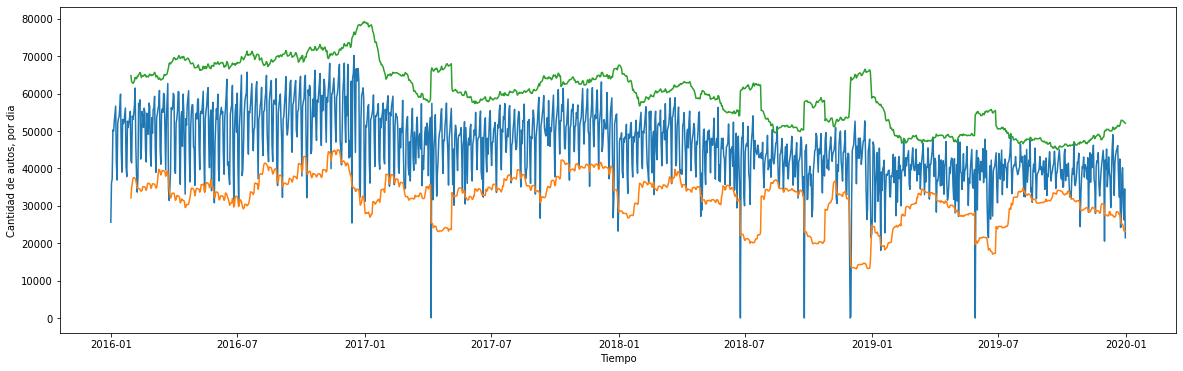

In [22]:
#Defino una ventana de 30 días

wind =30
sigma = 2

dataset_2016_2019["inferior"] = dataset_2016_2019.cantidad_pasos.rolling(window=wind)\
    .mean() - (sigma * dataset_2016_2019.cantidad_pasos.rolling(window=wind).std())
dataset_2016_2019["superior"] = dataset_2016_2019.cantidad_pasos.rolling(window=wind)\
    .mean() + (sigma * dataset_2016_2019.cantidad_pasos.rolling(window=wind).std())

dataset_2016_2019['anom']=dataset_2016_2019.apply(lambda x: x['cantidad_pasos'] if (x['cantidad_pasos'] <= x['inferior'] or x['cantidad_pasos']>=x['superior'] ) else 0,axis=1)

plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.inferior)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.superior)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

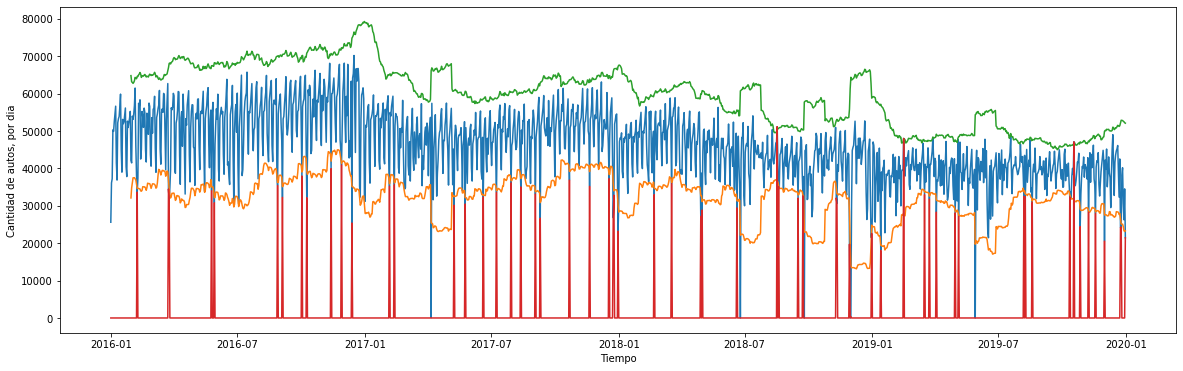

In [23]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.inferior)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.superior)
plt.plot(dataset_2016_2019.index, dataset_2016_2019.anom)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [24]:
dataset_2016_2019.cantidad_pasos=dataset_2016_2019.apply(lambda x: x['cantidad_pasos'] if (x['anom']==0) else np.nan,axis=1)
dataset_2016_2019.cantidad_pasos=dataset_2016_2019.cantidad_pasos.replace(0,np.nan)
dataset_2016_2019.loc[dataset_2016_2019.anom!=0]

,cantidad_pasos,inferior,superior,anom
fecha2,,,,
2016-02-08,NaN,34635.947653,64624.119013,33661.0
2016-03-24,NaN,36906.949232,66936.784102,34499.0
2016-03-25,NaN,34573.020120,68090.246546,31431.0
2016-05-25,NaN,35063.819494,67475.713840,34024.0
2016-05-29,NaN,32161.136691,68258.863309,30796.0
...,...,...,...,...
2019-11-18,NaN,28343.912500,48437.754167,27937.0
2019-12-01,NaN,27530.375633,49940.291033,20553.0
2019-12-24,NaN,26616.516603,52186.016730,24220.0


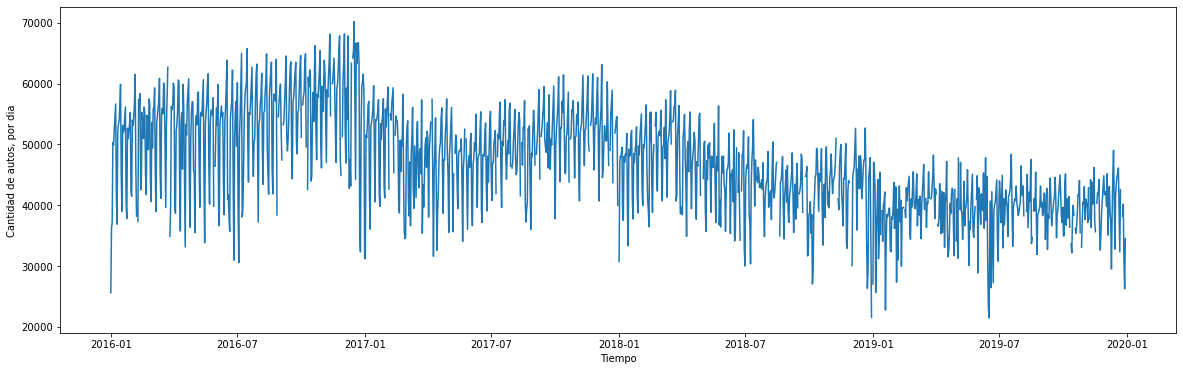

In [25]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [26]:
dataset_2016_2019.drop(['inferior','superior','anom'],axis=1,inplace=True)

print("El dataset tiene los siguientes valores nulos:")
dataset_2016_2019.isnull().sum()

El dataset tiene los siguientes valores nulos:


cantidad_pasos    66
dtype: int64

In [27]:
dataset_2016_2019 =dataset_2016_2019.interpolate()

print("El dataset de diario tiene los siguientes valores nulos:")
dataset_2016_2019.isnull().sum()

El dataset de diario tiene los siguientes valores nulos:


cantidad_pasos    0
dtype: int64

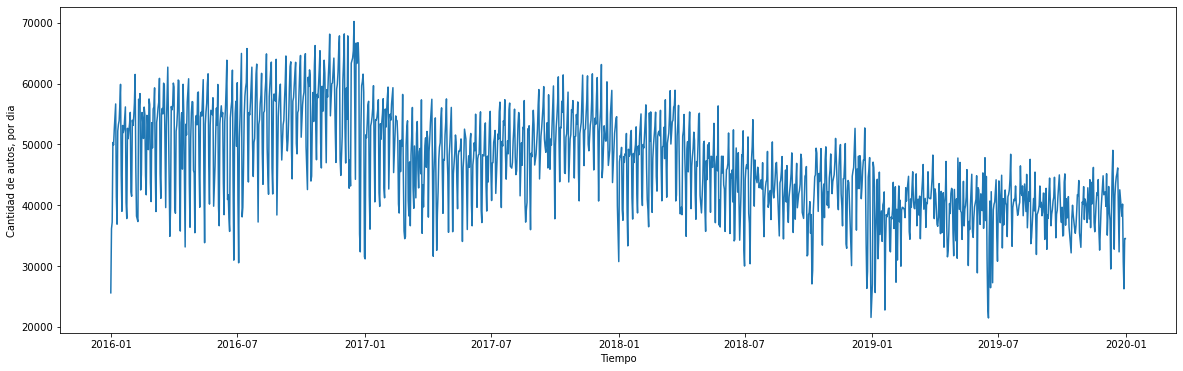

In [28]:
plt.figure(figsize = (20,6))
plt.plot(dataset_2016_2019.index, dataset_2016_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [29]:
dataset_2016_2019['tipo_vehiculo']=tipo_vehiculo
dataset_2016_2019['sentido']=sentido

dataset_2016_2019.head()

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2016-01-01,25602.0,Pesado,Centro
2016-01-02,36136.0,Pesado,Centro
2016-01-03,37225.0,Pesado,Centro
2016-01-04,50312.0,Pesado,Centro
2016-01-05,49907.0,Pesado,Centro


In [30]:
dataset_2016_2019.isnull().sum()

cantidad_pasos    0
tipo_vehiculo     4
sentido           4
dtype: int64

Como se puede observar, sigo teniendo los siguientes valores nulos:

In [31]:
dataset_2016_2019[dataset_2016_2019.tipo_vehiculo.isnull()==True]

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-25,38312.5,NaN,NaN
2018-09-25,41299.5,NaN,NaN
2018-11-30,36899.5,NaN,NaN
2019-05-29,40353.5,NaN,NaN


In [32]:
dataset_2016_2019[dataset_2016_2019.sentido.isnull()==True]

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-25,38312.5,NaN,NaN
2018-09-25,41299.5,NaN,NaN
2018-11-30,36899.5,NaN,NaN
2019-05-29,40353.5,NaN,NaN


Voy a utilizar el metodo pad de fillna para reemplazar los valores nulos con el valor del día anterior

In [33]:
dataset_2016_2019.loc[dataset_2016_2019.index == '2018-06-24']

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-24,34255.0,Pesado,Centro


In [34]:
dataset_2016_2019['tipo_vehiculo'].fillna(method='pad', inplace=True)
dataset_2016_2019['sentido'].fillna(method='pad', inplace=True)

In [35]:
dataset_2016_2019.loc[dataset_2016_2019.index == '2018-06-25']

,cantidad_pasos,tipo_vehiculo,sentido
fecha2,,,
2018-06-25,38312.5,Pesado,Centro


In [36]:
dataset_2016_2019.sentido.isnull().sum()

0

Transformación de variables categóricas en numéricas

In [37]:
dataset_2016_2019.tipo_vehiculo.value_counts()

Pesado     1094
Liviano     367
Name: tipo_vehiculo, dtype: int64

In [38]:
dataset_2016_2019.tipo_vehiculo=np.where(dataset_2016_2019.tipo_vehiculo=='Pesado',0,1)

In [39]:
dataset_2016_2019.sentido.value_counts()

Centro       1348
Provincia     113
Name: sentido, dtype: int64

In [40]:
dataset_2016_2019.sentido=np.where(dataset_2016_2019.sentido=='Centro',0,1)

#### Armado de los datasets de entrenamiento y testeo

Como se vío en el Proyecto 03, con datos de series temporales, la secuencia de valores es importante. Voy a aplicar el mismo método de one step prediction, pero en este caso no es tan secillo porque no tengo una sola variable, sino 3, es decir, estoy en un caso de análisis de series temporales multivariado. Para transformar el dataset en un problema de análisis supervisado tengo que considerar  el valor de cantidad_pasos en t y debería poder considerar también las 4 variables para cada uno de los 28 días anteriores, lo cual me da 3x28 columnas. Esto se lleva a cabo por medio de la función series_to_supervised. Considero nuevamente un lookback de 28 días.

In [41]:
ds=dataset_2016_2019
values = ds.values
data = series_to_supervised(values, 28, 1)
pd.DataFrame(data)

,var1(t-28),var2(t-28),var3(t-28),var1(t-27),var2(t-27),var3(t-27),var1(t-26),var2(t-26),var3(t-26),var1(t-25),var2(t-25),var3(t-25),var1(t-24),var2(t-24),var3(t-24),var1(t-23),var2(t-23),var3(t-23),var1(t-22),var2(t-22),var3(t-22),var1(t-21),var2(t-21),var3(t-21),var1(t-20),var2(t-20),var3(t-20),var1(t-19),var2(t-19),var3(t-19),var1(t-18),var2(t-18),var3(t-18),var1(t-17),var2(t-17),var3(t-17),var1(t-16),var2(t-16),var3(t-16),var1(t-15),var2(t-15),var3(t-15),var1(t-14),var2(t-14),var3(t-14),var1(t-13),var2(t-13),var3(t-13),var1(t-12),var2(t-12),var3(t-12),var1(t-11),var2(t-11),var3(t-11),var1(t-10),var2(t-10),var3(t-10),var1(t-9),var2(t-9),var3(t-9),var1(t-8),var2(t-8),var3(t-8),var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),var2(t-4),var3(t-4),var1(t-3),var2(t-3),var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
28,25602.0,0.0,0.0,36136.0,0.0,0.0,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.000000,0.0,0.0,40479.000000,0.0,0.0,37808.000000,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.0,0.0,0.0,55258.0,0.0,0.0
29,36136.0,0.0,0.0,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.000000,0.0,0.0,37808.000000,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.0,0.0,0.0,42187.0,0.0,0.0
30,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.000000,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.000000,0.0,0.0,42187.0,0.0,0.0,41477.0,0.0,0.0
31,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.000000,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.000000,0.0,0.0,42187.000000,0.0,0.0,41477.0,0.0,0.0,53972.0,0.0,0.0
32,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.000000,0.0,0.0,52301.000000,0.0,0.0,53411.000000,0.0,0.0,55258.000000,0.0,0.0,42187.000000,0.0,0.0,41477.000000,0.0,0.0,53972.0,0.0,0.0,53116.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,44841.0,1.0,0.0,41722.0,1.0,0.0,41968.5,1.0,1.0,42215.0,1.0,0.0,39820.0,1.0,0.0,45181.0,1.0,0.0,35084.0,1.0,0.0,38676.0,1.0,0.0,43076.0,1.0,0.0,38839.0,1.0,0.0,37518.0,1.0,0.0,29518.0,1.0,0.0,38546.0,1.0,0.0,45099.0,1.0,0.0,49027.0,1.0,

Como dije anteriormente, voy a predecir los valores en el tiempo t utilizando un look back de 28 días. Mi variable objetivo es la cantidad de pasos.

In [42]:
X=data.drop(['var1(t)','var2(t)','var3(t)'],axis=1)
y=data[['var1(t)']]

X_columns=X.columns

X=X.values
y=y.values

In [56]:
look_back=7*4

N_train = 365*3+270- look_back # 3 años + 3 trimestres
N_test = 90 # 1 trimestre
N_total = N_train + N_test

length_total = N_train + N_test + look_back

X_train = X[:N_train,:]
y_train = y[:N_train]
print(X_train.shape, y_train.shape)

X_test = X[N_train:N_train+N_test,:]
y_test = y[N_train:N_train+N_test]
print(X_test.shape, y_test.shape)

(1337, 84) (1337, 1)
(90, 84) (90, 1)


### Normalización

C:\Users\arrua\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


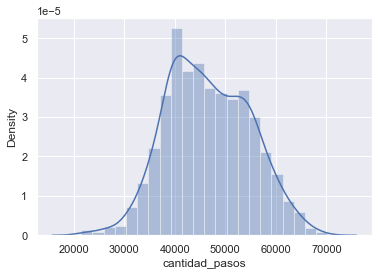

In [44]:
sns.set()
sns.distplot(dataset_2016_2019.cantidad_pasos)
plt.show()

Como se puede ver, la distribución no es normal por lo cual utilizaré MinMaxScaler


Con el fin de evitar que la información sobre la distribución del conjunto de test se filtre en el modelo, se debe ajustar el escalador solo en los datos de entrenamiento, luego estandarizar los conjuntos de entrenamiento y de prueba con ese escalador. Al ajustar el escalador en el conjunto de datos completo antes de dividirlo la información sobre el conjunto de test se usa para transformar el conjunto de entrenamiento.

In [45]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,25602.0,0.0,0.0,36136.0,0.0,0.0,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.0,0.0,0.0,52301.0,0.0,0.0,53411.0,0.0,0.0
1,36136.0,0.0,0.0,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.0,0.0,0.0,52301.0,0.0,0.0,53411.0,0.0,0.0,55258.0,0.0,0.0
2,37225.0,0.0,0.0,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.0,0.0,0.0,52301.0,0.0,0.0,53411.0,0.0,0.0,55258.0,0.0,0.0,42187.0,0.0,0.0
3,50312.0,0.0,0.0,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.0,0.0,0.0,52301.0,0.0,0.0,53411.0,0.0,0.0,55258.0,0.0,0.0,42187.0,0.0,0.0,41477.0,0.0,0.0
4,49907.0,0.0,0.0,52492.0,0.0,0.0,54514.0,0.0,0.0,56645.0,0.0,0.0,41449.0,0.0,0.0,36882.0,0.0,0.0,52186.0,0.0,0.0,53295.0,0.0,0.0,53885.0,0.0,0.0,56429.0,0.0,0.0,59870.0,0.0,0.0,44985.0,0.0,0.0,38999.0,0.0,0.0,53109.0,0.0,0.0,51946.0,0.0,0.0,52463.0,0.0,0.0,54254.0,0.0,0.0,56158.0,0.0,0.0,40479.0,0.0,0.0,37808.0,0.0,0.0,52645.0,0.0,0.0,50942.0,0.0,0.0,52301.0,0.0,0.0,53411.0,0.0,0.0,55258.0,0.0,0.0,42187.0,0.0,0.0,41477.0,0.0,0.0,53972.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1332,31905.0,1.0,0.0,38482.0,1.0,0.0,38760.0,1.0,0.0,39207.0,1.0,0.0,39986.0,1.0,0.0,43164.0,1.0,0.0,39703.0,1.0,0.0,40473.0,1.0,0.0,38274.0,1.0,0.0,38869.0,1.0,0.0,41994.0,1.0,0.0,41954.0,1.0,0.0,34380.0,1.0,1.0,38023.0,1.0,0.0,42777.0,1.0,0.0,32750.0,1.0,0.0,38391.0,1.0,0.0,37842.0,1.0,0.0,41912.0,1.0,0.0,44463.0,1.0,0.0,40606.0,1.0,0.0,36628.0,1.0,0.0,38539.0,1.0,0.0,39293.0,1.0,1.0,40707.0,1.0,0.0,41326.0,1.0,0.0,44596.0,1.0,0.0,40820.0,1.0,1.0
1333,38482.0,1.0,0.0,38760.0,1.0,0.0,39207.0,1.0,0.0,39986.0,1.0,0.0,43164.0,1.0,0.0,39703.0,1.0,0.0,40473.0,1.0,0.0,38274.0,1.0,0.0,38869.0,1.0,0.0,41994.0,1.0,0.0,41954.0,1.0,0.0,34380.0,1.0,1.0,38023.0,1.0,0.0,42777.0,1.0,0.0,32750.0,1.0,0.0,38391.0,1.0,0.0,37842.0,1.0,0.0,41912.0,1.0,0.0,44463.0,1.0,0.0,40606.0,1.0,0.0,36628.0,1.0,0.0,38539.0,1.0,0.0,39293.0,1.0,1.0,40707.0,1.0,0.0,41326.0,1.0,0.0,44596.0,1.0,0.0,40820.0,1.0,1.0,34646.0,1.0,0.0
1334,38760.0,1.0,0.0,39207.0,1.0,0.0,39986.0,1.0,0.0,43164.0,1.0,0.0,39703.0,1.0,0.0,40473.0,1.0,0.0,38274.0,1.0,0.0,38869.0,1.0,0.0,41994.0,1.0,0.0,41954.0,1.0,0.0,34380.0,1.0,1.0,38023.0,1.0,0.0,42777.0,1.0,0.0,32750.0,1.0,0.0,38391.0,1.0,0.0,37842.0,1.0,0.0,

In [46]:
normalizer = MinMaxScaler()
ct = ColumnTransformer([("MinMax", normalizer, slice(0, 85, 3))],remainder='passthrough')

In [47]:
X_train_normalized=ct.fit_transform(X_train)
X_train_normalized=pd.DataFrame(X_train_normalized)

X_test_normalized=ct.fit_transform(X_train)
X_test_normalized=pd.DataFrame(X_train_normalized)

In [48]:
X_train_normalized.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,0.084807,0.300960,0.323306,0.591846,0.583535,0.636578,0.678069,0.721796,0.409981,0.316268,0.630299,0.653055,0.665162,0.717364,0.787971,0.482538,0.359708,0.649239,0.625374,0.635983,0.672734,0.711803,0.390077,0.335269,0.639718,0.604773,0.632659,0.655436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.300960,0.323306,0.591846,0.583535,0.636578,0.678069,0.721796,0.409981,0.316268,0.630299,0.653055,0.665162,0.717364,0.787971,0.482538,0.359708,0.649239,0.625374,0.635983,0.672734,0.711803,0.390077,0.335269,0.639718,0.604773,0.632659,0.655436,0.693335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
X_test_normalized.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,0.084807,0.300960,0.323306,0.591846,0.583535,0.636578,0.678069,0.721796,0.409981,0.316268,0.630299,0.653055,0.665162,0.717364,0.787971,0.482538,0.359708,0.649239,0.625374,0.635983,0.672734,0.711803,0.390077,0.335269,0.639718,0.604773,0.632659,0.655436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.300960,0.323306,0.591846,0.583535,0.636578,0.678069,0.721796,0.409981,0.316268,0.630299,0.653055,0.665162,0.717364,0.787971,0.482538,0.359708,0.649239,0.625374,0.635983,0.672734,0.711803,0.390077,0.335269,0.639718,0.604773,0.632659,0.655436,0.693335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_train_normalized.reset_index(drop=True, inplace=True)
X_test_normalized.reset_index(drop=True, inplace=True)

### Configuración de la red multicapa

In [71]:
model = Sequential()
model.add(Dense(8, input_dim=84, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
669/669 - 1s - loss: 68657616.0000
Epoch 2/200
669/669 - 0s - loss: 36613448.0000
Epoch 3/200
669/669 - 0s - loss: 28813746.0000
Epoch 4/200
669/669 - 0s - loss: 26321934.0000
Epoch 5/200
669/669 - 0s - loss: 25593246.0000
Epoch 6/200
669/669 - 0s - loss: 24552132.0000
Epoch 7/200
669/669 - 0s - loss: 23428854.0000
Epoch 8/200
669/669 - 0s - loss: 22559986.0000
Epoch 9/200
669/669 - 0s - loss: 22550626.0000
Epoch 10/200
669/669 - 0s - loss: 22395244.0000
Epoch 11/200
669/669 - 0s - loss: 22429326.0000
Epoch 12/200
669/669 - 0s - loss: 21412338.0000
Epoch 13/200
669/669 - 0s - loss: 21429400.0000
Epoch 14/200
669/669 - 0s - loss: 21687178.0000
Epoch 15/200
669/669 - 0s - loss: 21823678.0000
Epoch 16/200
669/669 - 0s - loss: 21235638.0000
Epoch 17/200
669/669 - 0s - loss: 20712594.0000
Epoch 18/200
669/669 - 0s - loss: 20693010.0000
Epoch 19/200
669/669 - 0s - loss: 21030484.0000
Epoch 20/200
669/669 - 0s - loss: 21222008.0000
Epoch 21/200
669/669 - 0s - loss: 21547660.0000
E

In [72]:
# Estimacion del rendimiento del modelo

import math 
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Puntuacion de entrenamiento: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Puntuacion del test: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Puntuacion de entrenamiento: 18963082.00 MSE (4354.66 RMSE)
Puntuacion del test: 12698695.00 MSE (3563.52 RMSE)


In [73]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

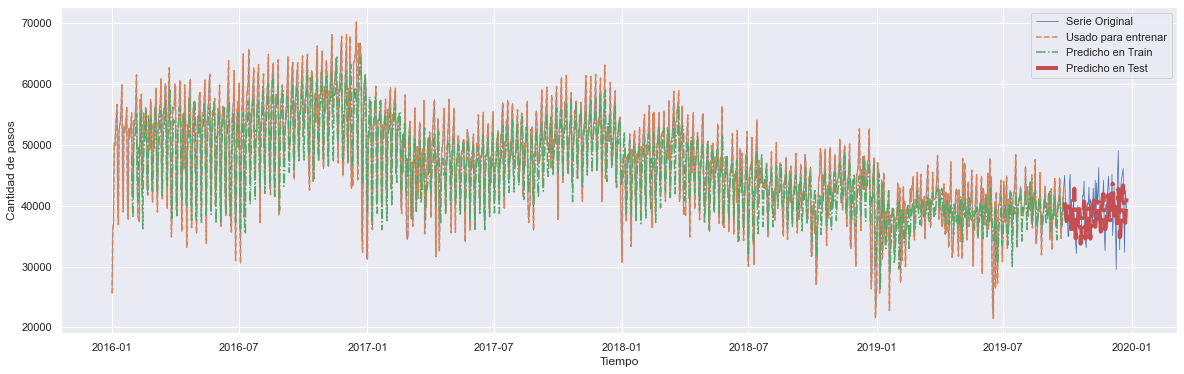

In [74]:
plt.figure(figsize=(20,6))
plt.plot(dataset_2016_2019.index[:length_total], dataset_2016_2019[:length_total].cantidad_pasos,lw = 0.75, label = 'Serie Original')
plt.plot(dataset_2016_2019.index[:N_train + look_back], dataset_2016_2019[:N_train + look_back].cantidad_pasos,'--', label = 'Usado para entrenar')
plt.plot(dataset_2016_2019.index[look_back: look_back + N_train], y_train_pred,'-.',label = 'Predicho en Train')
plt.plot(dataset_2016_2019.index[N_train+look_back: length_total], y_test_pred,'-.', lw = 4, label = 'Predicho en Test')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos')
plt.show()